In [1]:
import os
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, Function
from torch.nn import init
#dtype = torch.cuda.FloatTensor
dtype = torch.FloatTensor

In [2]:
def save_checkpoint(state,filename):
    torch.save(state, filename)  
    print("State Saved")
    print(filename)

In [3]:
areanumbers = [18]#,2,3,3,5,6,7,8,9,10,11,12,13,14,15,16]

batchsize=1
#Train 80% of the dataset 
train_test_split =3208
val_amount = 0

def hours_to_datestring(t):
    t=int(t)
    start = datetime.datetime(1950,1,1)
    delta = datetime.timedelta(hours=t)
    return (start+delta).strftime('%Y-%m-%d %H:%M:%S')
# Limit to 2017-12-23 for standardisation
times = np.load('dataset/times.npy')[:365*11]
print(hours_to_datestring(times[0]))
print(hours_to_datestring(times[3292]))

areatemps=[]
for i in areanumbers:
    print(i)
    nextarea = (np.load(f'dataset/by-area/area{i}.npy')[:365*11])
    # Ignore leap days
    for j in range(365):
        days = nextarea[j::365]
        days -= np.mean(days)
        days /= np.std(days)
    areatemps.append(nextarea)
areatemps = np.array(areatemps)
print(nextarea.shape)

def input_indices(end_indices):
    a = end_indices[:,None]
    return np.concatenate((a-4,a-3,a-2,a-1),axis=1)

def new_size(size):
    return torch.Size((size[0]*size[1],))+size[2:]
#train_val_beginnings = 4+np.random.permutation(train_test_split-4)
train_val_beginnings = 4+np.arange(train_test_split-4)

train_inputs = torch.from_numpy(areatemps[:,input_indices(train_val_beginnings[val_amount:])]).type(dtype)
train_inputs = train_inputs.view(new_size(train_inputs.size()))
print(train_inputs.shape)

train_ends = torch.from_numpy(areatemps[:,train_val_beginnings[val_amount:]]).type(dtype)
train_ends = train_ends.view(new_size(train_ends.size()))
print(train_ends.shape)

train_data = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_inputs,train_ends),
                                         batch_size=batchsize, shuffle=False
                                        )

2006-12-27 12:00:00
2016-01-01 12:00:00
18
(4015, 64, 64)
torch.Size([3204, 4, 64, 64])
torch.Size([3204, 64, 64])


In [4]:
def k(distsq,D,dt):
    return torch.exp(-distsq/(4*D*dt))/(4*np.pi*D*dt)
def gradientk(dist,D,dt):
    return dist*torch.exp(-(dist**2).sum(1)/(4*D*dt))/(8*np.pi*D**2*dt**2)
class GaussianConvolution(Function):
    D = 0.45
    dt = 1
    @staticmethod
    def forward(ctx, w, I):
        ctx.save_for_backward(w,I)
        interval=torch.arange(I.size()[-1]).type(dtype)
        x1 = interval[None,:,None,None,None]
        x2 = interval[None,None,:,None,None]
        y1 = interval[None,None,None,:,None]
        y2 = interval[None,None,None,None,:]
        distsq = (x1-y1-w[:,0,:,:,None,None])**2+(x2-y2-w[:,1,:,:,None,None])**2
        return (I[:,None,None,:,:]*k(distsq,GaussianConvolution.D,GaussianConvolution.dt)).sum(4).sum(3)
    
    @staticmethod
    def backward(ctx, grad_output):
        w,I = ctx.saved_variables
        w=w.data
        I=I.data
        interval=torch.arange(I.size()[-1]).type(dtype)
        x1 = interval[None,:,None,None,None]
        x2 = interval[None,None,:,None,None]
        y1 = interval[None,None,None,:,None]
        y2 = interval[None,None,None,None,:]
        distx = (x1-w[:,0,:,:,None,None]-y1)[:,None,:,:,:,:].repeat(1,1,1,1,1,I.size()[-1])
        disty = (x2-w[:,1,:,:,None,None]-y2)[:,None,:,:,:,:].repeat(1,1,1,1,I.size()[-1],1)
        dist = torch.cat((distx,disty),dim=1)
        grad = Variable((I[:,None,None,:,:]*gradientk(dist,GaussianConvolution.D,GaussianConvolution.dt)).sum(5).sum(4), requires_grad=False)
        #I(x) only depends on w(x) and not on w(z) for z != x
        return grad*grad_output[:,None,:,:], None

In [5]:
def charbonnier(x):
    epsilon = 0
    alpha = 0.5
    return (x+epsilon)**(1/alpha)

def grad_charbonnier(x):
    epsilon = 0
    alpha = 0.5
    return (1/alpha)*((x+epsilon)**((1/alpha)-1))

def Compute_Sideloss(F):
    gradient=reduce(np.add,np.gradient(F))
    Divergence=np.array([np.mean(gradient.sum(0)**2)])
    Magnitude=np.array([np.mean(np.linalg.norm(F,axis=0,ord=2)**2)])
    Smoothness=np.array([np.mean(np.linalg.norm(gradient,axis=0,ord=2)**2)])
    return torch.from_numpy(Divergence).type(dtype), torch.from_numpy(Magnitude).type(dtype), torch.from_numpy(Smoothness).type(dtype)
    
class Charbonnier_Loss(Function):
    @staticmethod
    def forward(ctl,y_pred, y, w):
        ctl.save_for_backward(y_pred, y)
        l_div=1
        l_magn=-0.1
        l_grad=0.4
        Divergence, Magnitude, Smoothness=Compute_Sideloss(w[0,:,:,:].numpy())        
        return charbonnier(y_pred-y).mean()+l_div*Divergence+l_magn*Magnitude+l_grad*Smoothness
    @staticmethod
    def backward(ctl,somegradient):
        y_pred, y = ctl.saved_variables
        return grad_charbonnier(y_pred-y),None,None

In [6]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_EncoderBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3,padding=1)
        self.bn1 =  nn.BatchNorm2d(in_channels)
        self.lr1 =  nn.LeakyReLU(0.1,inplace=True)
        self.cv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bn2 =  nn.BatchNorm2d(out_channels)
        self.lr2 =  nn.LeakyReLU(0.1,inplace=True)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=1)
        
    def forward(self, x):
        residual=x
        #print("residual",residual.shape)
        out=self.cv1(x)
        #print("cv1",out.shape)
        out=self.bn1(out)
        #print("bn1",out.shape)
        out=self.lr1(out)
        #print("lr1",out.shape)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.maxp(out)
        return out

class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.cv1 =     nn.Conv2d(in_channels, in_channels, kernel_size=3,padding=1)
        self.bn1 =     nn.BatchNorm2d(in_channels)
        self.lr1 =     nn.LeakyReLU(0.1,inplace=True)
        self.cv2 =     nn.Conv2d(in_channels, middle_channels, kernel_size=3)
        self.bn2 =     nn.BatchNorm2d(middle_channels)
        self.lr2 =     nn.LeakyReLU(0.1,inplace=True)
        self.tcv =     nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3)
        
    def forward(self, x):
        residual=x
        #print("residual",residual.shape)
        out=self.cv1(x)
        #print("cv1",out.shape)
        out=self.bn1(out)
        #print("bn1",out.shape)
        out=self.lr1(out)
        #print("lr1",out.shape)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.tcv(out)
        return out

class _CenterBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_CenterBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels,in_channels , kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.lr1 = nn.LeakyReLU(0.1,inplace=True)
        self.cv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.lr2 = nn.LeakyReLU(0.1,inplace=True)
        self.tcv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3)
        
    def forward(self, x):
        residual=x
        out=self.cv1(x)
        out=self.bn1(out)
        out=self.lr1(out)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.tcv(out)
        return out

class CDNN(nn.Module):
    def __init__(self,k):
        super(CDNN, self).__init__()
        self.enc1 = _EncoderBlock(k,64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512)
        self.dec4= _CenterBlock(512, 386)
        self.dec3 = _DecoderBlock(386+256, 256, 194)
        self.dec2 = _DecoderBlock(194+128, 128, 98)
        self.dec1 = _DecoderBlock(98+64, 64, 2)
        self.final = nn.Sequential(
            nn.Conv2d(2,2, kernel_size=3),
        )
        initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        #print("x",x.shape)
        #print("enc1",enc1.shape)
        enc2 = self.enc2(enc1)
        #print("enc2",enc2.shape)
        enc3 = self.enc3(enc2)
        #print("enc3",enc3.shape)
        enc4 = self.enc4(enc3)
        #print("enc4",enc4.shape)
        dec4 = self.dec4(enc4)
        #print("dec4",dec4.shape)
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        #print("dec3",dec3.shape)
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        #print("dec2",dec2.shape)
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        W=F.upsample(final, x.size()[2:], mode='bilinear')
        #print("W",W.shape)

        return W

In [7]:
net = CDNN(4)
warping = GaussianConvolution.apply
loss_fn = Charbonnier_Loss.apply
learning_rate=1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

In [ ]:
learning_rate=1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
Iter_Size=12

for epoch in range(27,100):
    print("epoch = ",epoch)
    step=0
    while step< len(train_data)-Iter_Size:
        optimizer.zero_grad()
        iter_loss=0
        i=0
        while(i<Iter_Size):
            Input, Target = next(iter(train_data))
            i=i+1
            step=step+1
            Input = Variable(Input,requires_grad=False)
            Target = Variable(Target)
            w = net(Input)
            y_pred = warping(w, Input[:,-1])
                
            loss = loss_fn(y_pred, Target,w)/Iter_Size
            loss.backward()
            iter_loss+=loss.data[0]
            
        print(step,iter_loss)
        losses.append(iter_loss)
        optimizer.step()
    filename="models/Charbonnier/CDNN_Charbonnier_Epoch={}.pth".format(epoch)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': net.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'losses'    : losses,
    },filename)    

epoch =  27
12 122.39862442016602
24 748.5420684814453
36 383.2473449707031
48 199.72402954101562
60 347.86205291748047
72 178.62253189086914
84 103.10175704956055
96 105.30622100830078
108 78.69367790222168
120 50.28749084472656
132 40.599549293518066
144 36.27066707611084
156 30.461108207702637
168 27.320383071899414
180 24.251933097839355
192 22.56614112854004
204 22.890018939971924
216 22.71206045150757
228 22.564417362213135
240 22.511216640472412
252 21.777427196502686
264 20.518826007843018
276 19.214595794677734
288 18.281076908111572
300 17.556843280792236
312 16.475452423095703
324 15.255894184112549
336 14.37703800201416
348 13.832210540771484
360 13.563756465911865
372 13.612230777740479
384 13.889249324798584
396 14.053017139434814
408 13.943155288696289
420 13.786221027374268
432 13.825284004211426
444 14.018631935119629
456 14.15315294265747
468 14.183059215545654
480 14.168622493743896
492 14.115114212036133
504 13.958569049835205
516 13.655386447906494
528 13.294519901

1044 33.88356685638428
1056 34.03787612915039
1068 36.169724464416504
1080 34.89327907562256
1092 34.32655334472656
1104 35.90702819824219
1116 35.43602657318115
1128 35.22613048553467
1140 35.254417419433594
1152 35.60059833526611
1164 35.63851833343506
1176 34.95907974243164
1188 36.25093746185303
1200 35.94611835479736
1212 35.704997062683105
1224 36.72517776489258
1236 35.945860862731934
1248 36.09803867340088
1260 36.420653343200684
1272 36.692999839782715
1284 36.016573905944824
1296 36.32767868041992
1308 37.21410083770752
1320 36.359493255615234
1332 36.967185974121094
1344 36.71041774749756
1356 37.132670402526855
1368 36.83723545074463
1380 37.581722259521484
1392 37.18377685546875
1404 37.30915546417236
1416 37.41568851470947
1428 37.458632469177246
1440 37.6060094833374
1452 37.801629066467285
1464 37.75217056274414
1476 37.52265930175781
1488 38.185458183288574
1500 37.8436803817749
1512 38.26955509185791
1524 37.78465175628662
1536 38.78122329711914
1548 37.04516315460205

2088 46.482069969177246
2100 45.9102258682251
2112 39.89564895629883
2124 39.54448413848877
2136 43.91102313995361
2148 44.69371318817139
2160 40.82157611846924
2172 39.95331859588623
2184 42.002583503723145
2196 42.346455574035645
2208 40.108574867248535
2220 40.70848846435547
2232 43.252784729003906
2244 43.907320976257324
2256 42.23345947265625
2268 39.64533233642578
2280 40.37021541595459
2292 43.47557544708252
2304 43.73522472381592
2316 42.21683406829834
2328 41.68670654296875
2340 42.29195308685303
2352 43.74943542480469
2364 42.84824752807617
2376 42.082271575927734
2388 43.57789993286133
2400 44.611106872558594
2412 44.36027240753174
2424 42.8955602645874
2436 42.55591106414795
2448 43.71296310424805
2460 43.93169116973877
2472 43.43476581573486
2484 42.7355260848999
2496 43.99592971801758
2508 44.99327373504639
2520 43.62567615509033
2532 43.5089635848999
2544 44.202223777770996
2556 45.27894115447998
2568 45.26177501678467
2580 44.07067108154297
2592 44.45294952392578
2604 4

3156 49.58370780944824
3168 49.225868225097656
3180 50.37349891662598
3192 50.52861213684082
State Saved
models/Charbonnier/CDNN_Charbonnier_Epoch=30.pth
epoch =  31
12 49.73555374145508
24 50.25821113586426
36 49.73773384094238
48 49.987627029418945
60 50.88961601257324
72 50.136159896850586
84 50.32533073425293
96 50.67858695983887
108 49.862016677856445
120 50.706281661987305
132 51.13992691040039
144 50.84097862243652
156 51.3973503112793
168 50.67710494995117
180 50.7286319732666
192 51.20147895812988
204 50.78108024597168
216 51.36978721618652
228 51.17670249938965
240 51.136287689208984
252 51.58944511413574
264 51.227027893066406
276 51.6207332611084
288 51.28330993652344
300 50.95594596862793
312 51.615028381347656
324 51.52960395812988
336 51.73333168029785
348 51.58612060546875
360 51.41897392272949
372 51.575735092163086
384 51.62756538391113
396 51.64750099182129
408 51.72719192504883
420 51.3995361328125
432 51.51369094848633
444 51.32464027404785
456 51.39203453063965
46

1032 52.842058181762695
1044 53.9337272644043
1056 52.45089912414551
1068 53.839651107788086
1080 53.00105094909668
1092 53.24569129943848
1104 53.37202262878418
1116 53.27319145202637
1128 53.20472717285156
1140 54.23632621765137
1152 52.41713333129883
1164 54.69698524475098
1176 52.07695198059082
1188 54.31805992126465
1200 51.921621322631836
1212 53.6612663269043
1224 52.03444862365723
1236 53.159934997558594
1248 51.50441551208496
1260 52.959028244018555
1272 52.816022872924805
1284 51.23959922790527
1296 52.89965057373047
1308 48.87563896179199
1320 52.77894973754883
1332 51.89301109313965
1344 48.97028160095215
1356 53.31164360046387
1368 51.02164077758789
1380 49.67805862426758
1392 53.37951850891113
1404 48.75453758239746
1416 49.83207321166992
1428 53.77920913696289
1440 48.57996368408203
1452 50.13195991516113
1464 53.27390098571777
1476 50.25728416442871
1488 49.3293399810791
1500 52.309295654296875
1512 50.91126823425293
1524 49.78613090515137
1536 52.16315460205078
1548 51

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('Loss')
plt.suptitle("Charbonnier Loss for Area {0}".format(areanumbers[0]))
plt.show()

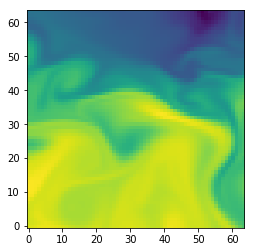

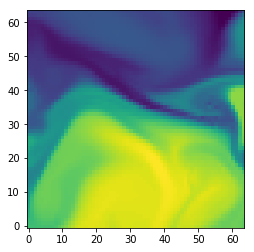

In [9]:
plt.figure()
plt.imshow(train_ends[-1].cpu().numpy(),origin='lower')
plt.show()
plt.figure()
plt.imshow(y_pred.data[0].cpu().numpy(),origin='lower')
plt.show()

In [ ]:
#net.training == True
#.eval()
#.train()

# for loading
#net2=CDNN(4)
#net2.load_state_dict(torch.load(filename))
#net2.eval()

#checkpoint = torch.load(filename)
#start_epoch = checkpoint['epoch']
#net2.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer'])
#L=checkpoint['losses']